In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()


/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/alberta/anaconda2/envs/pangeo-cloud/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
c

Client Scheduler: tcp://127.0.0.1:42139 Dashboard: http://127.0.0.1:34527/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [3]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
import numpy.ma as ma

today=date.today()

#pip install windrose 
from windrose import WindroseAxes
import matplotlib.pyplot as plt

from natl60_3_5_by_5_boxes import boxes

import seaborn as sns
sns.set(color_codes=True)

#https://pmall.univ-grenoble-alpes.fr/docs/auto_examples_code/windrose/windrose-exemple.html

In [4]:
data_dir = '/mnt/alberta/equipes/IGE/meom/MODEL_SET/NATL60/NATL60-CJM165-S/1h/gridT/'
gridfile='/mnt/alberta/equipes/IGE/meom/MODEL_SET/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':1000,'y':1000})

In [5]:
def dx_var(data,e1):
    dx_var = (data.shift(x=-1) - data)/e1
    return dx_var
def dy_var(data,e2):
    dy_var = (data.shift(x=-1) - data)/e2
    return dy_var
    

In [6]:
filetyps = {'votemper' : 'gridT', 'vosaline' : 'gridS'}
filedeps = {'votemper' : 'deptht','vosaline' : 'deptht'}
filee1 = {'votemper' : 'e1t','vosaline' : 'e1t'}

date='20120901' 
year=date[0:4]
month=date[4:6]
day=date[6:]
filename = sorted(glob.glob(data_dir+'/NATL60-CJM165_y'+str(year)+'m'+str(month)+'d'+str(day)+'.1h_gridT.nc'))
file=filename[0]
print(file)
ds=xr.open_dataset(file,chunks={'x':1000,'y':1000,'time_counter':1})
dataT=ds['sosstsst']
dataS=ds['sosaline']
e1=dsgrid['e1t'][0]
e2=dsgrid['e2t'][0]
dataT_dx=dx_var(dataT,e1)
dataS_dx=dx_var(dataS,e1)
dataT_dy=dy_var(dataT,e1)
dataS_dy=dy_var(dataS,e1)
R=(dataT_dx + 1j * dataT_dy)/(dataS_dx + 1j * dataS_dy)
magR=np.abs(R)
magR_ma=ma.masked_invalid(magR)
Tu=np.arctan(magR)



/mnt/alberta/equipes/IGE/meom/MODEL_SET/NATL60/NATL60-CJM165-S/1h/gridT//NATL60-CJM165_y2012m09d01.1h_gridT.nc


In [7]:
for box in boxes:
    if box.name == 'AC':
        jmin=box.jmin
        jmax=box.jmax
        imin=box.imin
        imax=box.imax

In [8]:
magR_box=magR[:,jmin:jmax,imin:imax].stack(z=('x', 'y','time_counter'))
Tu_box=Tu[:,jmin:jmax,imin:imax].stack(z=('x', 'y','time_counter'))
    
magR_box_nonan=magR_box[~np.isnan(magR_box)]
Tu_box_nonan=Tu_box[~np.isnan(magR_box)]
magR_box_nonan_noinf=magR_box_nonan[~np.isinf(magR_box_nonan)]
Tu_box_nonan_noinf=Tu_box_nonan[~np.isinf(magR_box_nonan)]


In [13]:
magR_box_nonan_noinf=magR_box_nonan_noinf.reset_index('z')
dataset_mag=magR_box_nonan_noinf.to_dataset(name='magR')
dataset_mag.attrs['global_attribute']= 'Stack of absolute value of ratio between temperature and salinity gradient of data for day '+str(date)
dataset_mag.to_netcdf(path='NATL60-CJM165_magR_'+str(date)+'_AC.nc',mode='w')


In [14]:
Tu_box_nonan_noinf=Tu_box_nonan_noinf.reset_index('z')
dataset_mag=Tu_box_nonan_noinf.to_dataset(name='Tu')
dataset_mag.attrs['global_attribute']= 'Stack of turner angle of data for day '+str(date)
dataset_mag.to_netcdf(path='NATL60-CJM165_Tu_'+str(date)+'_AC.nc',mode='w')


Text(0.5, 1.0, 'turner angle - AC box')

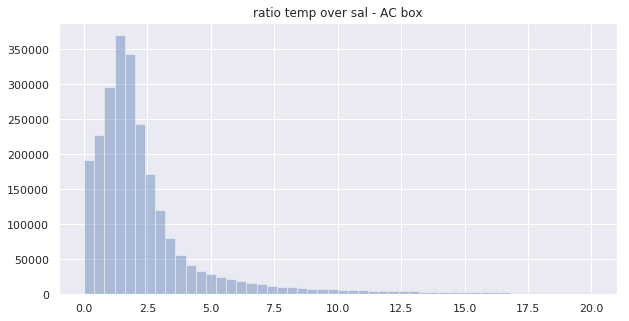

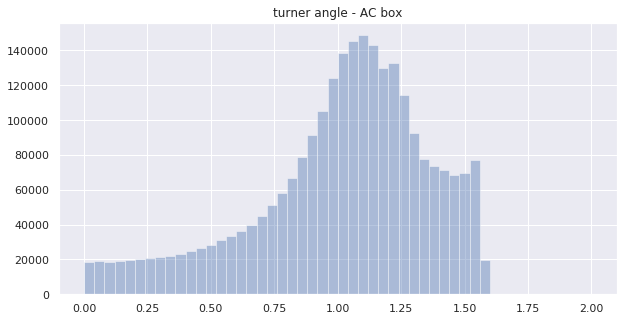

In [15]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes()    # creates the axes of specified dimensions

sns.distplot(magR_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,20]})
plt.title('ratio temp over sal - AC box')

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes()    # creates the axes of specified dimensions

sns.distplot(Tu_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,2]})
plt.title('turner angle - AC box')


In [ ]:
fig = plt.figure(figsize=(10, 5))

rectangle = [0.1, 0.1, 0.75, 0.75]
ax = WindroseAxes(fig,rectangle)
fig.add_axes(ax)
ax.bar(Tu_box_nonan_noinf*360/np.pi, magR_box_nonan_noinf, normed=True, opening=0.8, edgecolor='white', bins=np.arange(0,6, 1))
#ax.set_title("annual", position=(0.5, 1.1))

ax.set_legend()
#ax.legend(title="wind speed (m/s)", loc=(1.1, 0))

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


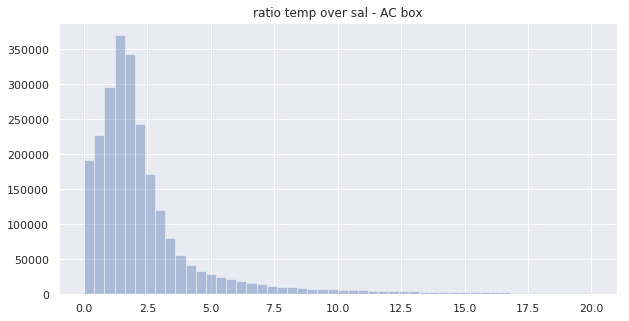

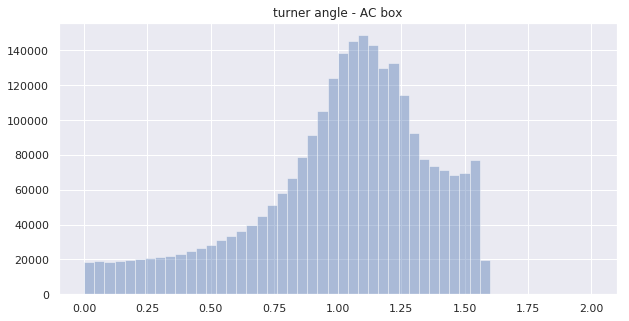

In [58]:
for box in boxes:
    if box.name == 'AC':
        magR_box=magR[:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
        Tu_box=Tu[:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
    
        magR_box_nonan=magR_box[~np.isnan(magR_box)]
        Tu_box_nonan=Tu_box[~np.isnan(magR_box)]
        magR_box_nonan_noinf=magR_box_nonan[~np.isinf(magR_box_nonan)]
        Tu_box_nonan_noinf=Tu_box_nonan[~np.isinf(magR_box_nonan)]
        
        fig = plt.figure(figsize=(10, 5))

        ax1 = fig.add_axes()    # creates the axes of specified dimensions

        sns.distplot(magR_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,20]})
        plt.title('ratio temp over sal - AC box')

        fig = plt.figure(figsize=(10, 5))

        ax1 = fig.add_axes()    # creates the axes of specified dimensions

        sns.distplot(Tu_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,2]})
        plt.title('turner angle - AC box')


In [ ]:
for box in boxes:
    if box.name == 'AC':
        magR_box=magR[:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
        Tu_box=Tu[:,box.jmin:box.jmax,box.imin:box.imax].stack(z=('x', 'y','time_counter'))
    
        magR_box_nonan=magR_box[~np.isnan(magR_box)]
        Tu_box_nonan=Tu_box[~np.isnan(magR_box)]
        magR_box_nonan_noinf=magR_box_nonan[~np.isinf(magR_box_nonan)]
        Tu_box_nonan_noinf=Tu_box_nonan[~np.isinf(magR_box_nonan)]
        
        dataset_mag=magR_box_nonan_noinf.to_dataset()
        dataset_mag[str(var)].attrs=data.attrs
        dataset_mag.attrs['global_attribute']= var+' profile averaged over 24h and in '+box.name+' computed on occigen with dask-jobqueue '+str(today)
        dataset_mag.to_netcdf(path='/scratch/cnt0024/hmg2840/albert7a/eNATL60/eNATL60-BLBT02-S/ANNA/eNATL60'+box.name+'-BLBT02_y'+date[0:4]+'m'+date[4:6]+'d'+date[6:9]+'_'+var+'-profile.nc',mode='w')


In [ ]:
fig = plt.figure(figsize=(10, 5))

rectangle = [0.1, 0.1, 0.75, 0.75]
ax = WindroseAxes(fig,rectangle)
fig.add_axes(ax)
ax.bar(Tu_box_nonan_noinf*360/np.pi, magR_box_nonan_noinf, normed=True, opening=0.8, edgecolor='white', bins=np.arange(0,6, 1))
#ax.set_title("annual", position=(0.5, 1.1))

ax.set_legend()
#ax.legend(title="wind speed (m/s)", loc=(1.1, 0))